In [1]:
# This is a copy of my private kaggle kernel: https://www.kaggle.com/joatom/nn-model
# fork of https://www.kaggle.com/inversion/atomic-distance-benchmark/

#J-Coupling:https://www.youtube.com/watch?v=vnkk3eli1Hc

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from fastai.tabular import *
from fastai.callbacks import *

import gc
import psutil
import os
import time
from functools import reduce

print(os.listdir("../input"))

['champs-scalar-coupling', 'main-features']


In [2]:
#https://github.com/LiyuanLucasLiu/RAdam/blob/master/radam.py


In [3]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error as mmse
from sklearn.metrics import mean_absolute_error as mmae

# General Functions

In [4]:
in_path='../input/champs-scalar-coupling/'
mf_path='../input/main-features/'

In [5]:
#train=pd.read_pickle(mf_path+'train_ext_1JHN.zip',compression='zip')
#train.info(max_cols=200) #head()
#train[['2J_nn','nn2_1']].describe()

In [6]:
#train.nn7_0.head(10)

In [7]:
# https://www.kaggle.com/todnewman/keras-neural-net-for-champs/comments
def show_ram_usage():
    py = psutil.Process(os.getpid())
    print('RAM usage: {} GB'.format(py.memory_info()[0]/2. ** 30))

In [8]:
# https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
# https://www.kaggle.com/c/champs-scalar-coupling/discussion/96655#latest-565815
# guiferviz comment

def reduce_memory_usage(df, deep=True, verbose=True, categories=True):
    # All types that we want to change for "lighter" ones.
    # int8 and float16 are not include because we cannot reduce
    # those data types.
    # float32 is not include because float16 has too low precision.
    numeric2reduce = ["int16", "int32", "int64", "float64"]
    start_mem = 0
    if verbose:
        start_mem = df.memory_usage().sum() / 1024**2

    for col, col_type in df.dtypes.iteritems():
        best_type = None
        if col_type == "object":
            df[col] = df[col].astype("category")
            best_type = "category"
        elif col_type in numeric2reduce:
            downcast = "integer" if "int" in str(col_type) else "float"
            df[col] = pd.to_numeric(df[col], downcast=downcast)
            best_type = df[col].dtype.name
        # Log the conversion performed.
        if verbose and best_type is not None and best_type != str(col_type):
            print(f"Column '{col}' converted from {col_type} to {best_type}")

    if verbose:
        end_mem = df.memory_usage().sum() / 1024**2
        diff_mem = start_mem - end_mem
        percent_mem = 100 * diff_mem / start_mem
        print(f"Memory usage decreased from"
              f" {start_mem:.2f}MB to {end_mem:.2f}MB"
              f" ({diff_mem:.2f}MB, {percent_mem:.2f}% reduction)")
    return df

In [9]:
# https://www.kaggle.com/c/champs-scalar-coupling/discussion/93972

def crit_loss(predict, coupling_value):
    predict = predict.view(-1)
    coupling_value = coupling_value.view(-1)
    assert(predict.shape==coupling_value.shape)

    loss = torch.abs(predict-coupling_value)
    loss = loss.mean()
    loss = torch.log(loss)
    return loss

In [10]:
#https://medium.com/@lessw/new-state-of-the-art-ai-optimizer-rectified-adam-radam-5d854730807b
optar =partial(RAdam)

# NN

In [11]:

wctn_num=8
path = Path('../input')

np.random.seed(2019)

fin_preds_idx =[]
fin_valid_idx =[]
fin_train_idx =[]

fin_preds =[]
fin_preds_valid=[]
fin_preds_train=[]
y_valid_nn_a =[]
y_train_nn_a =[]

ras_all=[]
raa_all=[]
raa_all_train=[]

procs = [FillMissing, Categorify, Normalize]
bs= 256

dep_var = 'scalar_coupling_constant'



In [12]:
show_ram_usage()

RAM usage: 0.2522010803222656 GB


In [13]:
#train.groupby('type')['x_0'].count()

In [14]:
#train[dep_var].hist(by=train['type'],figsize=(10,10))

In [15]:
#X[(X['scalar_coupling_constant']>190) & (X['type']=='1JHC')] #.groupby('type').count()
#train['type'].unique()

In [16]:
#https://forums.fast.ai/t/solved-reproducibility-where-is-the-randomness-coming-in/31628/4 
def random_seed(seed_value):
    import random 
    random.seed(seed_value) # Python
    import numpy as np
    np.random.seed(seed_value) # cpu vars
    import torch
    torch.manual_seed(seed_value) # cpu  vars
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False

In [17]:
# https://github.com/fastai/fastai/blob/master/fastai/tabular/models.py
def conv1d(ni:int, no:int, ks:int=1, stride:int=1, padding:int=0, bias:bool=False):
    "Create and initialize a `nn.Conv1d` layer with spectral normalization."
    conv = nn.Conv1d(ni, no, ks, stride=stride, padding=padding, bias=bias)
    nn.init.kaiming_normal_(conv.weight)
    if bias: conv.bias.data.zero_()
    return spectral_norm(conv)

class MyTabularModel(TabularModel):
    "Basic model for tabular data."
    def __init__(self, emb_szs:ListSizes, n_cont:int, out_sz:int, layers:Collection[int], ps:Collection[float]=None,
                 emb_drop:float=0., y_range:OptRange=None, use_bn:bool=True, bn_final:bool=False):
        #super().__init__()
        ps = ifnone(ps, [0]*len(layers))
        ps = listify(ps, layers)
        self.embeds = nn.ModuleList([embedding(ni, nf) for ni,nf in emb_szs])
        self.emb_drop = nn.Dropout(emb_drop)
        self.bn_cont = nn.BatchNorm1d(n_cont)
        n_emb = sum(e.embedding_dim for e in self.embeds)
        self.n_emb,self.n_cont,self.y_range = n_emb,n_cont,y_range
        sizes = self.get_sizes(layers, out_sz)
        actns = [nn.ReLU6(inplace=True) for _ in range(len(sizes)-2)] + [None]
        print(actns)
        #actns[-5]=nn.ReLU6(inplace=True)
        #print(actns)
        layers = []
        for i,(n_in,n_out,dp,act) in enumerate(zip(sizes[:-1],sizes[1:],[0.]+ps,actns)):
            #if i==2:
             #   layers.append(conv1d(1, 1, 3))
            layers += bn_drop_lin(n_in, n_out, bn=use_bn and i!=0, p=dp, actn=act)
        if bn_final: layers.append(nn.BatchNorm1d(sizes[-1]))
        #layers +=conv_layer(ni=1, nf=1, ks=2, stride=1, bias=None, is_1d=True, 
        #       transpose=False, self_attention=False)
        self.layers = nn.Sequential(*layers)

In [18]:
%%time

types_to_run = ['3JHC', '2JHH', '1JHN', '2JHN', '2JHC', '3JHH', '1JHC', '3JHN'] #train['type'].unique() ## #['3JHC']:#['3JHC']:#['1JHN']#
n_cycle = 60

np.random.seed(2019)
for wctn in types_to_run:
    
    featuresJ2=['2J_nn','2J_angle']
    featuresJ3=['3J_nn','3J_angle','dihedral']
    featuresJ2cat=['2J_nn',]
    featuresJ3cat=['3J_nn',]
    features=['mulliken_charge_0','mulliken_charge_1',
              'atom_0','num_atoms_in_mol_x','nn1_0','nn1_dist_0','nn2_0','nn2_dist_0','nn3_0','nn3_dist_0','nn4_0','nn4_dist_0','nn5_0','nn5_dist_0','nn6_0',
              'nn6_dist_0','nn7_0','nn7_dist_0','nn8_0','nn8_dist_0','nn9_0','nn9_dist_0','atom_1','nn1_1','nn1_dist_1','nn2_1','nn2_dist_1','nn3_1','nn3_dist_1',
              'nn4_1','nn4_dist_1','nn5_1','nn5_dist_1','nn6_1','nn6_dist_1','nn7_1','nn7_dist_1','nn8_1','nn8_dist_1','nn9_1','nn9_dist_1',
              #'1','6','7','8','9',
              'C','F','H','N','O',
              'common_nn_0','common_nn_1','common_nn_dist_1','common_nn_2','common_nn_dist_2','common_nn_3','common_nn_dist_3','common_nn_4','common_nn_dist_4',
              'common_nn_5','common_nn_dist_5','common_nn_6','common_nn_dist_6','common_nn_7','common_nn_dist_7','common_nn_8','common_nn_dist_8','common_nn_9',
              'common_nn_dist_9',
              'nn_1_0_exists','nn_1_1_exists','nn_2_0_exists','nn_2_1_exists','nn_3_0_exists','nn_3_1_exists','nn_4_0_exists','nn_4_1_exists',
              'nn_5_0_exists','nn_5_1_exists','nn_6_0_exists','nn_6_1_exists','nn_7_0_exists','nn_7_1_exists','nn_8_0_exists','nn_8_1_exists','nn_9_0_exists',
              'nn_9_1_exists',
              'dist','dist_cos','dist_mol_c_0','dist_mol_c_1','dist_nn_0_1','dist_nn_1_1','dist_nn_0_2',
              'dist_nn_1_2','dist_nn_0_3','dist_nn_1_3','dist_nn_0_4','dist_nn_1_4','dist_nn_0_5','dist_nn_1_5','dist_nn_0_6','dist_nn_1_6','dist_nn_0_7',
              'dist_nn_1_7','dist_nn_0_8','dist_nn_1_8','dist_nn_0_9','dist_nn_1_9','bonds','y_min','y_max']
    if wctn in ['2JHC','3JHH']:
        features=features+['yukawa_0','yukawa_1'] #,'vander_0','vander_1']

    if wctn[0]=='99':
        featuresJ2=[]
        featuresJ2cat=[]
        featuresJ3=[]
        featuresJ3cat=[]
        i=0
    elif wctn[0]=='99':
        featuresJ3=[]
        featuresJ3cat=[]
    
    
    cat_names = ['C','F','H','N','O']+['nn'+str(i)+'_0' for i in range(1,9)]+['nn'+str(i)+'_1' for i in range(1,9)]

    #cat_names = ['atom_1', 'atom_0',
    #             'nn1_0','nn2_0','nn3_0','nn4_0','nn5_0','nn6_0','nn7_0','nn5_0','nn9_0',
    #             'nn1_1','nn2_1','nn3_1','nn4_1','nn5_1','nn6_1','nn7_1','nn8_1','nn9_1',
    #             'common_nn_0','common_nn_1','common_nn_2','common_nn_3','common_nn_4',
    #             'common_nn_5','common_nn_6',
    #             'common_nn_7','common_nn_8','common_nn_9',
    #             '2J_nn','3J_nn'
    #            ]
            
    #cont_names = list(set(train.columns)-set(cat_names+[dep_var,'type','id'])) 
    cont_names = list(set(features+featuresJ2+featuresJ3)-set(cat_names+[dep_var,'type','id'])) 
    #print(cat_names, cont_names)
    
    train=pd.read_pickle(mf_path+'train_ext_'+wctn+'.zip',compression='zip')
    test=pd.read_pickle(mf_path+'test_ext_'+wctn+'.zip',compression='zip')
    
    if wctn in ['2JHC','3JHH']:
        train['yukawa_0']= np.exp(-train['nn1_dist_0'])+np.exp(-train['nn2_dist_0'])+np.exp(-train['nn3_dist_0'])+np.exp(-train['nn4_dist_0'])+np.exp(-train['nn5_dist_0'])
        train['yukawa_1']= np.exp(-train['nn1_dist_1'])+np.exp(-train['nn2_dist_1'])+np.exp(-train['nn3_dist_1'])+np.exp(-train['nn4_dist_1'])+np.exp(-train['nn5_dist_1'])
        test['yukawa_0']= np.exp(-test['nn1_dist_0'])+np.exp(-test['nn2_dist_0'])+np.exp(-test['nn3_dist_0'])+np.exp(-test['nn4_dist_0'])+np.exp(-test['nn5_dist_0'])
        test['yukawa_1']= np.exp(-test['nn1_dist_1'])+np.exp(-test['nn2_dist_1'])+np.exp(-test['nn3_dist_1'])+np.exp(-test['nn4_dist_1'])+np.exp(-test['nn5_dist_1'])
        #train['vander_0']= 1/((train['nn1_dist_0']+1e-8)**3)+1/((train['nn2_dist_0']+1e-8)**3)+1/((train['nn3_dist_0']+1e-8)**3)+1/((train['nn4_dist_0']+1e-8)**3)#+np.exp(-train['nn5_dist_0'])
        #train['vander_1']= 1/((train['nn1_dist_1']+1e-8)**3)+1/((train['nn2_dist_1']+1e-8)**3)+1/((train['nn3_dist_1']+1e-8)**3)+1/((train['nn4_dist_1']+1e-8)**3)#+np.exp(-train['nn5_dist_1'])
        #test['vander_0']= 1/((test['nn1_dist_0']+1e-8)**3)+1/((test['nn2_dist_0']+1e-8)**3)+1/((test['nn3_dist_0']+1e-8)**3)+1/((test['nn4_dist_0']+1e-8)**3)#+np.exp(-test['nn5_dist_0'])
        #test['vander_1']= 1/((test['nn1_dist_1']+1e-8)**3)+1/((test['nn2_dist_1']+1e-8)**3)+1/((test['nn3_dist_1']+1e-8)**3)+1/((test['nn4_dist_1']+1e-8)**3)#+np.exp(-test['nn5_dist_1'])

    y_min=np.min(train[dep_var])
    y_max=np.max(train[dep_var])
    
    train['y_min']=y_min
    train['y_max']=y_max
    test['y_min']=y_min
    test['y_max']=y_max
    
    train=reduce_memory_usage(train[cat_names+cont_names+[dep_var,'type','id']])
    test=reduce_memory_usage(test[cat_names+cont_names+['type','id']])
    #print(train[['yukawa_0','yukawa_1']],test[['yukawa_0','yukawa_1']])
    gc.collect()
    show_ram_usage()
    
    #cat_names = ['atom_1', 'atom_0','nn1_0','nn2_0','nn3_0','nn4_0','nn5_0','nn6_0','nn1_1','nn2_1','nn3_1','nn4_1','nn5_1','nn6_1']
    #cont_names = list(set(train.columns)-set(cat_names+[dep_var,'type','id'])) 
    #cont_names = list(set(features)-set(cat_names+[dep_var,'type','id'])) 
    #print(cat_names, cont_names)
    
    print(wctn,'started...')
    y_train_wctn=train[train['type']==wctn][dep_var]
    id_train_wctn=train[train['type']==wctn]['id']
    X_train_wctn=train[train['type']==wctn].drop(['type','id'],axis=1).reset_index() 
    
    
    id_test_wctn=test[test['type']==wctn]['id']
    X_test_wctn=test[test['type']==wctn].drop(['type','id'],axis=1) 
    
    train = None
    test = None
    gc.collect()
    
    predsNN=[None]
    i=0
    print('Lets go: ',1)
    if True:
        X_len=len(X_train_wctn)
        random_seed(2019)
        valid_idx = random.sample(list(X_train_wctn.index.values), int(X_len*0.1) ) #0.2
        train_idx = list(set(list(X_train_wctn.index.values))-set(valid_idx))
        y_valid_nn = X_train_wctn[dep_var][valid_idx]
        y_train_nn = X_train_wctn[dep_var][train_idx]
        data = (TabularList.from_df(X_train_wctn, path=path, procs=procs,cont_names=cont_names)#,cat_names=cat_names)
                                .split_by_idx(valid_idx=valid_idx)
                                .label_from_df(cols=dep_var, label_cls=FloatList)#,log=True)
                                .add_test(TabularList.from_df(X_test_wctn, path=path, procs=procs,cont_names=cont_names),label=0) #,cat_names=cat_names
                               .databunch(bs=bs))
        #y_range=torch.tensor([y_train_wctn.min()-np.abs(y_train_wctn.min())*.005,y_train_wctn.max()+np.abs(y_train_wctn.max())*.005],device=defaults.device)
        #y_range=torch.tensor([y_train_wctn.min(),y_train_wctn.max()],device=defaults.device)
        y_range=torch.tensor([y_min,y_max],device=defaults.device)
        y_train_wctn=None
        gc.collect()
        #,emb_drop=0.05,
        
        #learn = tabular_learner(data, layers=[1024,1024,1024,512,256,128], ps=[0.01,0.01,0.01,0.01,0.01,0.01], path='.',metrics=mean_absolute_error,y_range=y_range,wd=1e-4)#.to_fp16()#, wd=1e-1)
        #,512,256,128
        if wctn in ['1JHC', '3JHH', '3JHN']:
            model = MyTabularModel(emb_szs={}, n_cont=len(data.cont_names), out_sz=data.c, layers=[1024, 1024,1024,1024,256,128], ps=[0.001,0.001,0.001,0.001,0.001,0.001],
                                 emb_drop=0,y_range=y_range, use_bn=True)
            print('2l**')
            learn = Learner(data, model, metrics=mean_absolute_error, path='.',opt_func=optar)
        elif wctn in ['2JHC']:          
            learn = tabular_learner(data, layers=[1024, 1024,1024,1024,256,128], ps=[0.001,0.001,0.001,0.001,0.001,0.001],
                                    path='.',metrics=mean_absolute_error,y_range=y_range,
                                    opt_func=optar)#,
                                    #bn_wd=False,true_wd=True,wd=1e-1)#.to_fp16()#, wd=1e-1)
            print('1l')
        else: 
            print('2l*')
            
            model = MyTabularModel(emb_szs={}, n_cont=len(data.cont_names), out_sz=data.c, layers=[1024, 1024,1024,1024,256,128], ps=[0.001,0.001,0.001,0.001,0.001,0.001],
                                 emb_drop=0,y_range=y_range, use_bn=True)
            #print('2l**')
            learn = Learner(data, model, metrics=mean_absolute_error, path='.')
            
            #learn = tabular_learner(data, layers=[1024, 1024,1024,1024,256,128], ps=[0.001,0.001,0.001,0.001,0.001,0.001],
            #                        path='.',metrics=mean_absolute_error,y_range=y_range)
            #
            #
            print('2l')
        #learn = tabular_learner(data, layers=[400,200,100,200], path='.',metrics=mean_absolute_error, ps=[0.001,0.01,0.001,0.001],y_range=y_range,wd=1e-2).to_fp16()#, wd=1e-1)
        print(i,'Data ready...')
        
        learn.loss_fn = F.l1_loss #crit_loss # F.mse_loss
        #learn.lr_find()
        #display(learn.recorder.plot())
        
#if False:
       
    # Train NN #
    lr = 1e-3
    reduceLR = ReduceLROnPlateauCallback(learn=learn, monitor = 'valid_loss', mode = 'auto', patience = 0, factor = 0.2, min_delta = 0)
    if wctn in ['1JHC', '2JHC', '3JHH', '3JHN']:
        learn.fit_one_cycle(n_cycle, callbacks=[reduceLR])
        print('1f')
    #elif wctn in ['2JHH']:
     #   learn.fit_one_cycle(n_cycle, slice(lr), pct_start=0.2,callbacks=[reduceLR])
    else:
        learn.fit_one_cycle(n_cycle, slice(lr), pct_start=0.2,callbacks=[reduceLR])
        print('2f')

    display(learn.recorder.plot_losses(),learn.recorder.plot_metrics())

    
    # Predictions #
    ## predict test (to be submitted) ##
    nn_preds_test,_ =learn.get_preds(ds_type=DatasetType.Test)
    fin_preds.append(np.array(nn_preds_test[:,0]))
    fin_preds_idx.append(np.array(id_test_wctn))
    
    ## predict train ##
    nn_preds_train,_ =learn.get_preds(ds_type=DatasetType.Fix)
    fin_preds_train.append(np.array(nn_preds_train[:,0]))
    fin_train_idx.append(np.array(id_train_wctn.iloc[train_idx]))
    
    ## predict valid ##
    nn_preds_valid,_ = learn.get_preds(ds_type=DatasetType.Valid)#,with_loss=True)
    fin_preds_valid.append(np.array(nn_preds_valid[:,0]))
    fin_valid_idx.append(np.array(id_train_wctn.iloc[valid_idx]))
    
    # original y values for comparision later on
    y_valid_nn_a.append(np.array(y_valid_nn))
    y_train_nn_a.append(np.array(y_train_nn))
    
    ### get scores from validation set
    raa=mmae(y_valid_nn, np.array(nn_preds_valid[:,0]))
    raa_all.append(raa)
    print(wctn,'mae valid', raa, 'len', len(X_test_wctn))
    
    raa_train=mmae(y_train_nn, np.array(nn_preds_train[:,0]))
    raa_all_train.append(raa_train)
    print(wctn,'mae train', raa_train, 'len', len(X_test_wctn))
    #print(wctn,'mae train', mmae(y_train_nn, np.array(nn_preds_train[:,0])))
    
    
    # clean memory #
    y_train_wctn=None
    X_train_wctn=None
    id_test_wctn=None
    X_test_wctn=None
    learn = None
    gc.collect()
    show_ram_usage()

# org:
# 1JHN mae valid 0.6196298 len 24195
# 1JHN mae train 0.4989671 len 24195
#0.7325483

/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

Column 'nn3_0' converted from int16 to int8
Column 'nn4_0' converted from int16 to int8
Column 'nn5_0' converted from int16 to int8
Column 'nn3_1' converted from int16 to int8
Column 'nn4_1' converted from int16 to int8
Column 'nn5_1' converted from int16 to int8
Column 'y_min' converted from float64 to float32
Column 'y_max' converted from float64 to float32
Memory usage decreased from 482.54MB to 462.37MB (20.17MB, 4.18% reduction)
Column 'nn4_0' converted from int16 to int8
Column 'nn4_1' converted from int16 to int8
Column 'y_min' converted from float64 to float32
Column 'y_max' converted from float64 to float32
Memory usage decreased from 254.77MB to 247.03MB (7.74MB, 3.04% reduction)
RAM usage: 1.2288360595703125 GB
3JHC started...
Lets go:  1
2l*
[ReLU6(inplace=True), ReLU6(inplace=True), ReLU6(inplace=True), ReLU6(inplace=True), ReLU6(inplace=True), ReLU6(inplace=True), None]
2l
0 Data ready...


epoch,train_loss,valid_loss,mean_absolute_error,time
0,2.009635,1.403594,0.855154,02:37
1,1.571602,1.175062,0.776293,02:39
2,1.414491,1.116368,0.737942,02:39


In [19]:
#1JHN mae valid 0.3754331 len 24195
#1JHN mae train 0.14405736 len 24195

In [20]:
#analyse_diff = X_train_wctn.merge(np.abs(predsNN-y_valid_nn).sort_values(ascending=False).to_frame(), left_index=True, right_index=True, copy=False)

#analyse_diff.sort_values(by='scalar_coupling_constant_y').tail(n=10)

In [21]:
np.mean(raa_all),raa_all, 'minVal of Preds:' ,[np.min(i) for i in fin_preds],'Train:',raa_all_train

(0.25378305,
 [0.2386142,
  0.14076486,
  0.31816846,
  0.1482291,
  0.25836468,
  0.14124516,
  0.68341124,
  0.10146656],
 'minVal of Preds:',
 [-17.881683,
  -27.349815,
  25.841011,
  -2.620379,
  -35.599133,
  -1.7896826,
  66.60285,
  -1.8613201],
 'Train:',
 [0.15448458,
  0.07915181,
  0.15842402,
  0.063235976,
  0.18444298,
  0.084697306,
  0.5288416,
  0.040988825])

In [22]:
#np.concatenate(fin_preds),np.concatenate(fin_preds_idx)

In [23]:

output = pd.DataFrame({'id': np.concatenate(fin_preds_idx),
                       'scalar_coupling_constant': np.concatenate(fin_preds)})
output.to_csv('submission_last.csv', index=False)



print('Done!')

Done!


In [24]:
output2 = pd.DataFrame({'id': np.append(np.concatenate(fin_valid_idx),np.concatenate(fin_train_idx)),
                       'scalar_coupling_constant': np.append(np.concatenate(fin_preds_valid),np.concatenate(fin_preds_train))})
output2.to_csv('train_valid.csv', index=False)



print('Done!')

Done!


(array([8.278300e+04, 1.992097e+06, 3.151900e+04, 1.602300e+04, 1.077180e+05, 2.092920e+05, 5.499500e+04, 6.259000e+03,
        4.000000e+00, 4.852000e+03]),
 array([-35.599133, -11.551222,  12.496689,  36.5446  ,  60.59251 ,  84.64042 , 108.68833 , 132.73624 , 156.78415 ,
        180.83206 , 204.87997 ], dtype=float32),
 <a list of 10 Patch objects>)

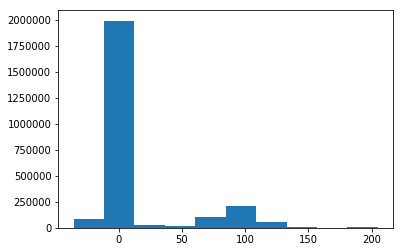

In [25]:

#train[dep_var].hist(), 
plt.hist(np.concatenate(fin_preds))

# ooValidation set

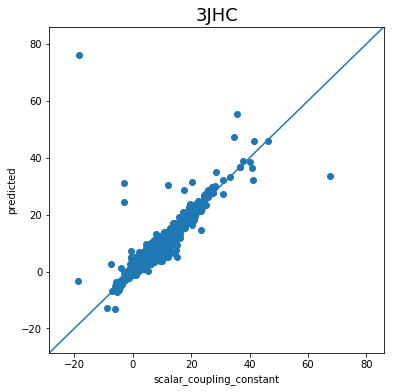

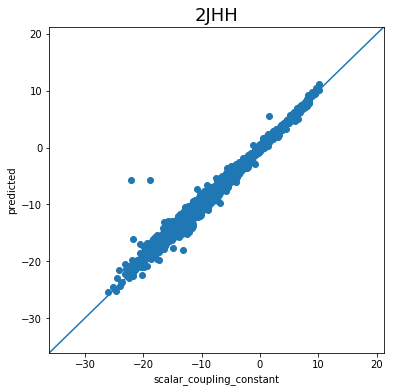

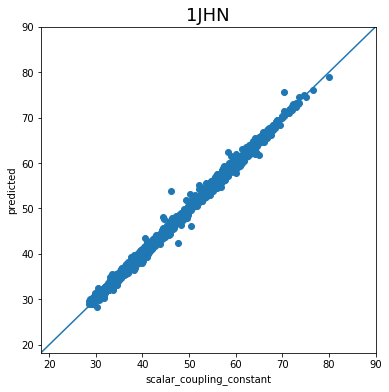

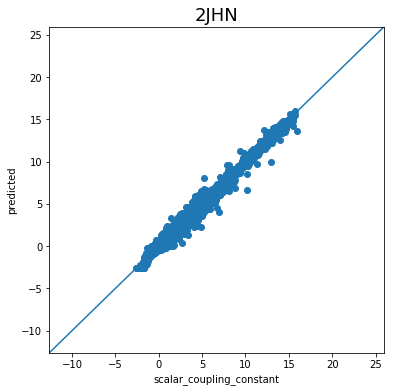

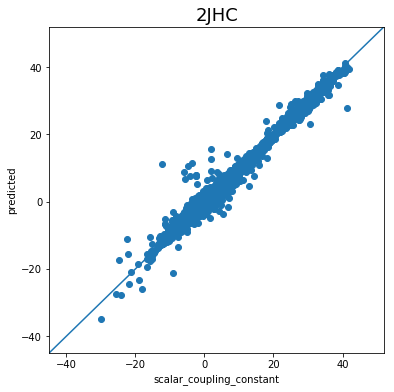

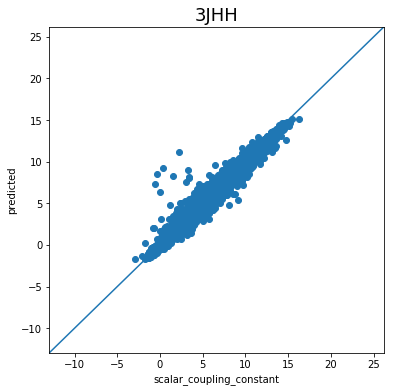

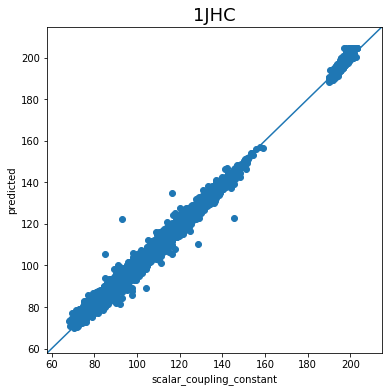

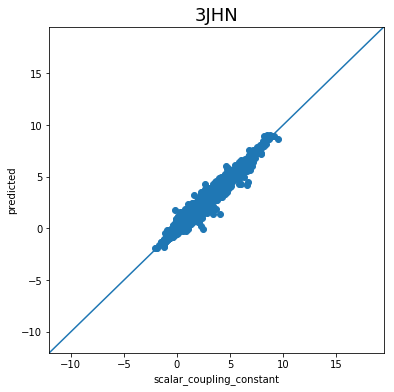

In [26]:
for i,t in enumerate(types_to_run):
    plt.figure(figsize=(6,6))
    plt.scatter(x=y_valid_nn_a[i], y=fin_preds_valid[i])
    
    llim =min(np.min(fin_preds_valid[i]),np.min(y_valid_nn_a[i]))-10
    ulim=max(np.max(fin_preds_valid[i]),np.max(y_valid_nn_a[i]))+10
    
    plt.xlabel('scalar_coupling_constant')
    plt.ylabel('predicted')
    plt.xlim((llim, ulim))
    plt.ylim((llim, ulim))
    plt.plot([llim, ulim], [llim, ulim])
    plt.title(t, fontsize=18)
    plt.show()

## oo Train Set

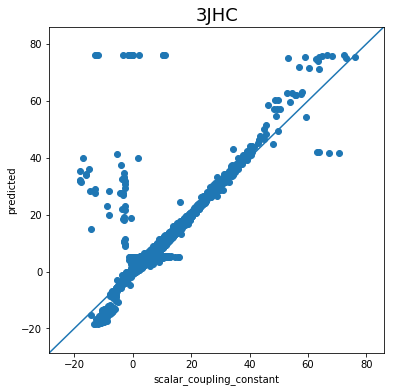

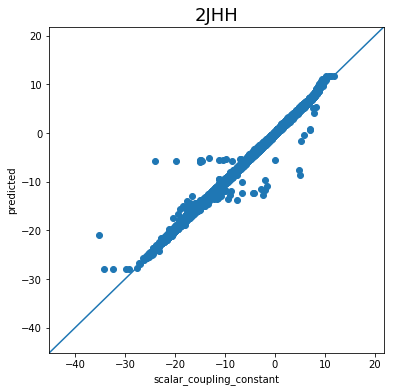

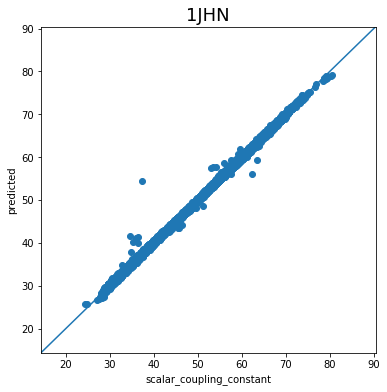

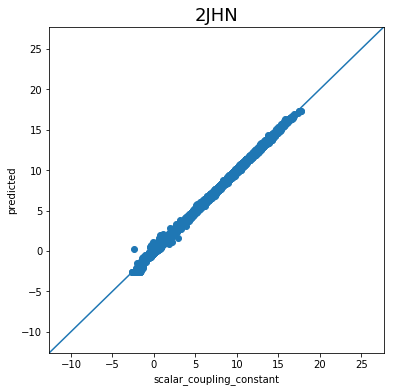

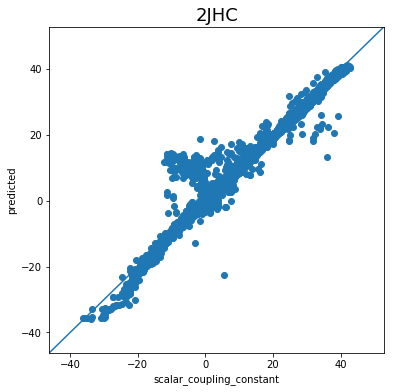

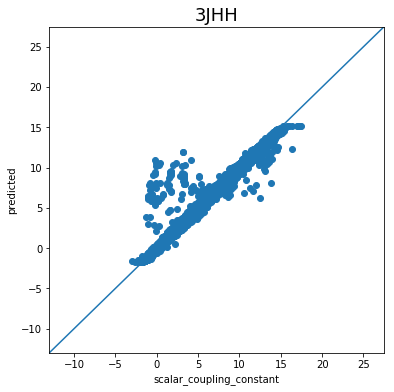

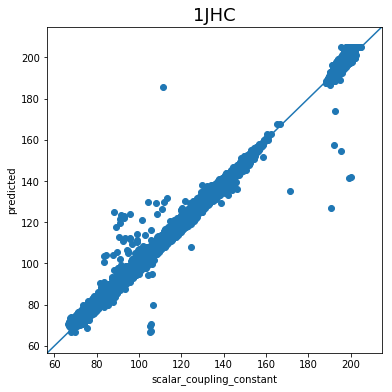

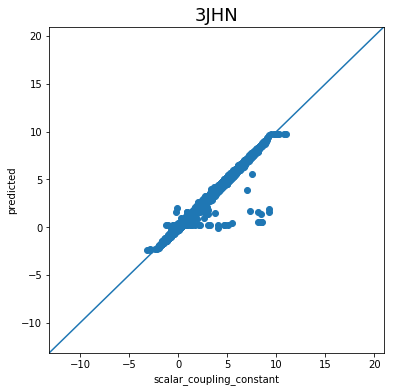

In [27]:
for i,t in enumerate(types_to_run):
    plt.figure(figsize=(6,6))
    plt.scatter(x=y_train_nn_a[i], y=fin_preds_train[i])
    
    llim =min(np.min(fin_preds_train[i]),np.min(y_train_nn_a[i]))-10
    ulim=max(np.max(fin_preds_train[i]),np.max(y_train_nn_a[i]))+10
    
    plt.xlabel('scalar_coupling_constant')
    plt.ylabel('predicted')
    plt.xlim((llim, ulim))
    plt.ylim((llim, ulim))
    plt.plot([llim, ulim], [llim, ulim])
    plt.title(t, fontsize=18)
    plt.show()

## Predictions

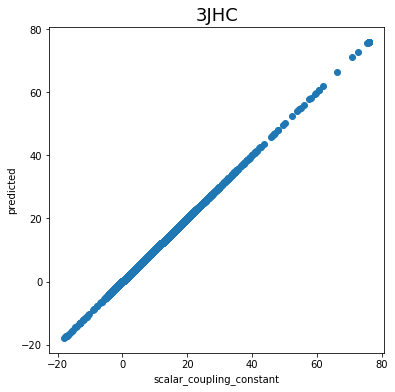

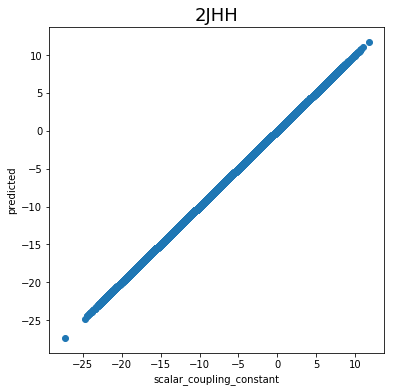

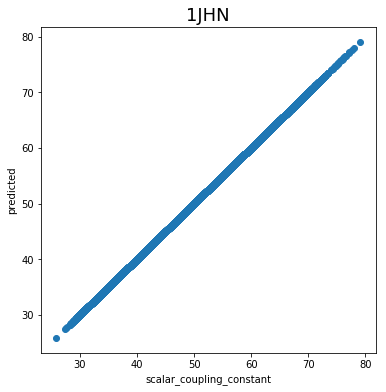

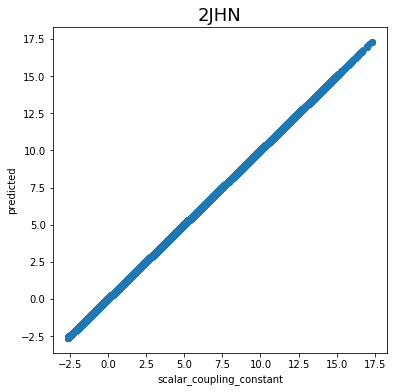

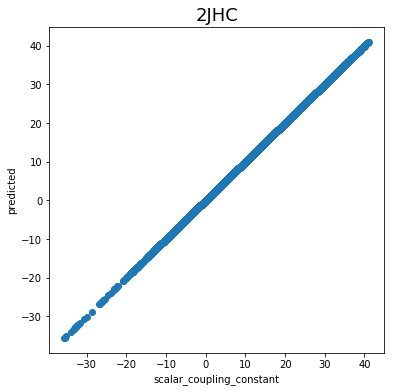

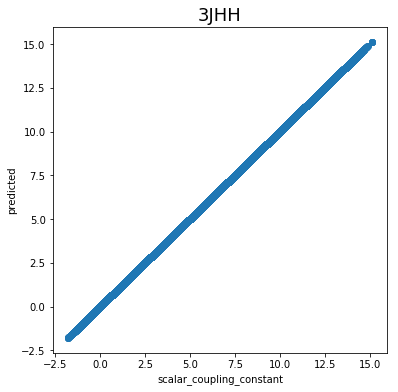

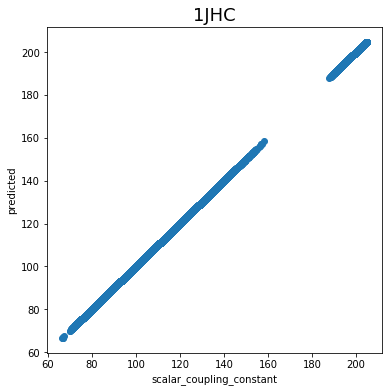

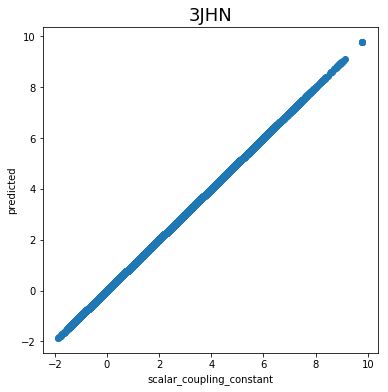

In [28]:
for i,t in enumerate(types_to_run):
    plt.figure(figsize=(6,6))
    
    plt.scatter(x=fin_preds[i], y=fin_preds[i])
    
    plt.xlabel('scalar_coupling_constant')
    plt.ylabel('predicted')
    plt.title(t, fontsize=18)
    plt.show()